In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/down_syndrome/archive.zip

/content/drive/MyDrive/down_syndrome/archive.zip


In [3]:
!unzip /content/drive/MyDrive/down_syndrome/archive.zip

Archive:  /content/drive/MyDrive/down_syndrome/archive.zip
  inflating: downSyndorme/downSyndrome/down_1.jpg  
  inflating: downSyndorme/downSyndrome/down_10.jpg  
  inflating: downSyndorme/downSyndrome/down_100.jpg  
  inflating: downSyndorme/downSyndrome/down_1000.jpg  
  inflating: downSyndorme/downSyndrome/down_1001.jpg  
  inflating: downSyndorme/downSyndrome/down_1002.jpg  
  inflating: downSyndorme/downSyndrome/down_1003.jpg  
  inflating: downSyndorme/downSyndrome/down_1004.jpg  
  inflating: downSyndorme/downSyndrome/down_1005.jpg  
  inflating: downSyndorme/downSyndrome/down_1006.jpg  
  inflating: downSyndorme/downSyndrome/down_1007.jpg  
  inflating: downSyndorme/downSyndrome/down_1008.jpg  
  inflating: downSyndorme/downSyndrome/down_1009.jpg  
  inflating: downSyndorme/downSyndrome/down_101.jpg  
  inflating: downSyndorme/downSyndrome/down_1010.jpg  
  inflating: downSyndorme/downSyndrome/down_1011.jpg  
  inflating: downSyndorme/downSyndrome/down_1012.jpg  
  inflating: 

In [4]:
!pwd

/content


In [5]:
!ls

downSyndorme  drive  healty  labeling.xlsx  sample_data


In [6]:
from IPython.display import clear_output
!pip install visualkeras
clear_output()

In [7]:
# Importing dependencies

import os
import random
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
import visualkeras

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 15
BATCH_SIZE = 8

In [8]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in tqdm(images, desc = 'images' ):
        full_path.append(os.path.join(path, i))

    return full_path


data_healthy = create_images_list('/content/healty/healty')
data_down = create_images_list('/content/downSyndorme/downSyndrome')


# look-up table
disease_classes = {0:'healthy', 1 : 'down' }

data_df = pd.concat([  pd.DataFrame({"img" : np.array(data_healthy) , "label": 0 }),
                        pd.DataFrame({"img" : np.array(data_down) , "label": 1 }) ], ignore_index = True)


data_df = shuffle(data_df).reset_index(drop = True)

images:   0%|          | 0/1499 [00:00<?, ?it/s]

images:   0%|          | 0/1500 [00:00<?, ?it/s]

In [9]:
# Creating random 4 sample from a dataframe


def create_img_label_sample(data, index):

    img = cv2.imread(data['img'][index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = disease_classes[data_df['label'][index]]

    return img, label


def create_random_samples(data):

    idx1,idx2,idx3,idx4 =np.random.permutation(data.shape[0])[:4]

    fig, axs = plt.subplots(1,4, figsize = (12,5), dpi = 300)

    img1, name1 = create_img_label_sample(data, idx1)
    img2, name2 = create_img_label_sample(data, idx2)
    img3, name3 = create_img_label_sample(data, idx3)
    img4, name4 = create_img_label_sample(data, idx4)


    axs[0].imshow(img1)
    axs[0].set_title(name1)
    axs[0].axis('off')

    axs[1].imshow(img2)
    axs[1].set_title(name2)
    axs[1].axis('off')

    axs[2].imshow(img3)
    axs[2].set_title(name3)
    axs[2].axis('off')

    axs[3].imshow(img4)
    axs[3].set_title(name4)
    axs[3].axis('off')

    plt.show()

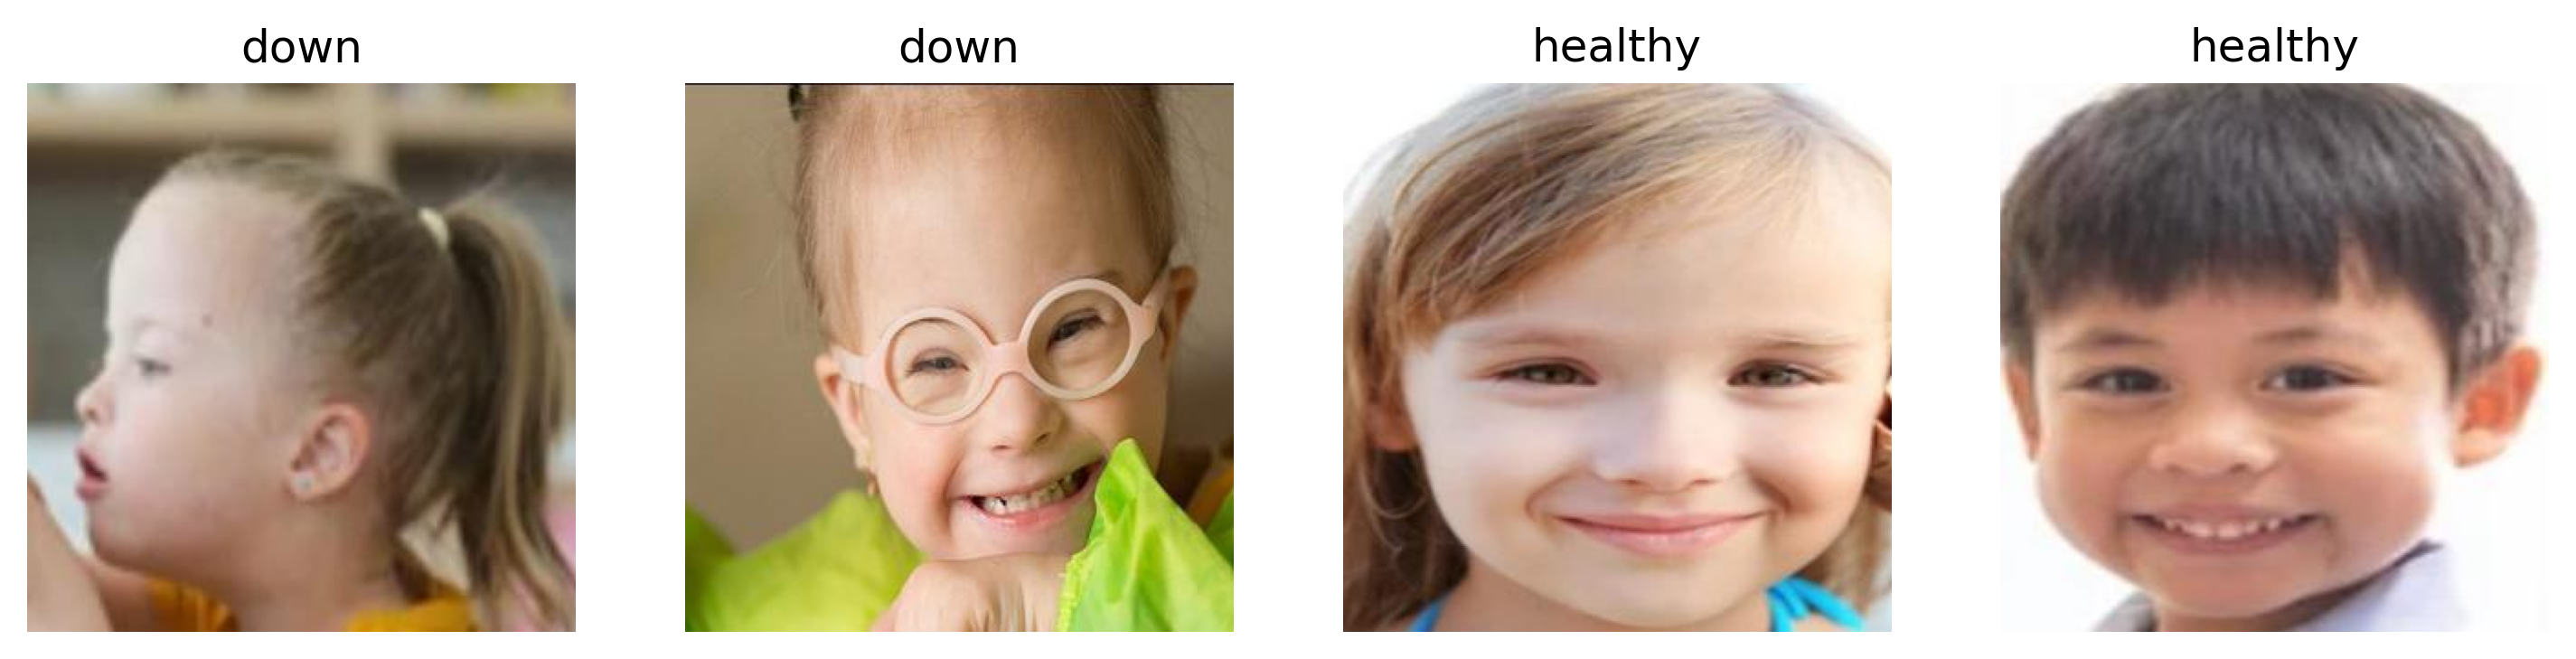

In [10]:
# Random samples

create_random_samples(data_df)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_df['img'], data_df['label'], test_size = 0.15,  random_state = SEED)

print("train images: ", X_train.shape[0])
print("test images: ", X_test.shape[0])

train images:  2549
test images:  450


In [12]:
X_train

264      /content/downSyndorme/downSyndrome/down_239.jpg
389      /content/downSyndorme/downSyndrome/down_307.jpg
103      /content/downSyndorme/downSyndrome/down_273.jpg
2532    /content/downSyndorme/downSyndrome/down_1152.jpg
1407    /content/downSyndorme/downSyndrome/down_1164.jpg
                              ...                       
1739               /content/healty/healty/healty_805.jpg
2715              /content/healty/healty/healty_1238.jpg
2204     /content/downSyndorme/downSyndrome/down_270.jpg
2432     /content/downSyndorme/downSyndrome/down_566.jpg
2693               /content/healty/healty/healty_158.jpg
Name: img, Length: 2549, dtype: object

In [13]:
from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        """
        img_paths: A list of paths to the images
        labels: A list of labels for the images
        transform: PyTorch transforms for image preprocessing
        """
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB to ensure 3 color channels
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [14]:
from torchvision import transforms

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

# Assuming y_train is a pandas Series of labels corresponding to X_train
img_paths = X_train.tolist()  # Convert Series to list
labels = y_train.tolist()  # Convert labels to list

# Create your custom dataset
dataset = CustomImageDataset(img_paths, labels, transform=transform)

# Create a DataLoader
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

######################

# Assuming y_train is a pandas Series of labels corresponding to X_train
img_paths = X_test.tolist()  # Convert Series to list
labels = y_test.tolist()  # Convert labels to list

# Create your custom dataset
dataset = CustomImageDataset(img_paths, labels, transform=transform)

# Create a DataLoader
from torch.utils.data import DataLoader

test_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# VGG

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Load a pre-trained VGG model
model = models.vgg16(pretrained=True)

# Modify the classifier for your dataset
num_features = model.classifier[6].in_features
num_classes = len(np.unique(y_train))  # Assuming y_train contains class labels
model.classifier[6] = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.9MB/s]


In [18]:
from tqdm import tqdm

In [19]:
num_epochs = 10  # You can adjust this

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

 10%|█         | 1/10 [01:12<10:50, 72.23s/it]

Epoch 1, Loss: 0.5318351924419403


 20%|██        | 2/10 [02:27<09:50, 73.81s/it]

Epoch 2, Loss: 0.29776434004306795


 30%|███       | 3/10 [03:40<08:35, 73.70s/it]

Epoch 3, Loss: 0.21897331140935422


 40%|████      | 4/10 [04:54<07:22, 73.69s/it]

Epoch 4, Loss: 0.13511455573607237


 50%|█████     | 5/10 [06:08<06:08, 73.72s/it]

Epoch 5, Loss: 0.06413778079440817


 60%|██████    | 6/10 [07:21<04:54, 73.70s/it]

Epoch 6, Loss: 0.03457448869739892


 70%|███████   | 7/10 [08:35<03:41, 73.76s/it]

Epoch 7, Loss: 0.013463058792694937


 80%|████████  | 8/10 [09:49<02:27, 73.78s/it]

Epoch 8, Loss: 0.04044221074946108


 90%|█████████ | 9/10 [11:06<01:14, 74.71s/it]

Epoch 9, Loss: 0.03329733855061932


100%|██████████| 10/10 [12:21<00:00, 74.13s/it]

Epoch 10, Loss: 0.022329603816979217


In [20]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0

# We won't be updating the weights, so we don't need to calculate the gradients
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader)}")
print(f"Accuracy on test set: {100 * correct / total}%")

Test Loss: 0.1861844071963181
Accuracy on test set: 94.66666666666667%


# Googlenet

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.hub

# Load a pre-trained GoogleNet model
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

# Assuming y_train contains class labels and is available
num_classes = len(np.unique(y_train))

# Modify the final fully connected layer for your dataset
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 142MB/s]


In [22]:
num_epochs = 10  # You can adjust this

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

 10%|█         | 1/10 [00:27<04:06, 27.42s/it]

Epoch 1, Loss: 0.6218009289354086


 20%|██        | 2/10 [00:54<03:37, 27.18s/it]

Epoch 2, Loss: 0.4413692194968462


 30%|███       | 3/10 [01:21<03:09, 27.11s/it]

Epoch 3, Loss: 0.3089784223586321


 40%|████      | 4/10 [01:48<02:42, 27.06s/it]

Epoch 4, Loss: 0.23368488596752285


 50%|█████     | 5/10 [02:15<02:15, 27.03s/it]

Epoch 5, Loss: 0.16031855437904596


 60%|██████    | 6/10 [02:42<01:47, 26.99s/it]

Epoch 6, Loss: 0.12092805719003082


 70%|███████   | 7/10 [03:09<01:20, 26.96s/it]

Epoch 7, Loss: 0.08861133926548063


 80%|████████  | 8/10 [03:36<00:53, 27.00s/it]

Epoch 8, Loss: 0.06441138635855168


 90%|█████████ | 9/10 [04:03<00:27, 27.01s/it]

Epoch 9, Loss: 0.039341149921529


100%|██████████| 10/10 [04:30<00:00, 27.04s/it]

Epoch 10, Loss: 0.030962213687598706


In [23]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0

# We won't be updating the weights, so we don't need to calculate the gradients
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader)}")
print(f"Accuracy on test set: {100 * correct / total}%")

Test Loss: 0.16795679504672686
Accuracy on test set: 93.77777777777777%


# InceptionV3




In [24]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.aux_logits = False  # Disable the auxiliary classifier
# Assuming y_train contains class labels and is available
num_classes = len(np.unique(y_train))

# Modify the final fully connected layer for your dataset
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 157MB/s] 


In [25]:
num_epochs = 10  # You can adjust this

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

 10%|█         | 1/10 [00:45<06:50, 45.61s/it]

Epoch 1, Loss: 0.5849007308483124


 20%|██        | 2/10 [01:28<05:53, 44.20s/it]

Epoch 2, Loss: 0.32783474661409856


 30%|███       | 3/10 [02:12<05:06, 43.83s/it]

Epoch 3, Loss: 0.17120894975960255


 40%|████      | 4/10 [02:55<04:22, 43.68s/it]

Epoch 4, Loss: 0.06926000812090934


 50%|█████     | 5/10 [03:39<03:38, 43.60s/it]

Epoch 5, Loss: 0.03981657635304146


 60%|██████    | 6/10 [04:22<02:54, 43.53s/it]

Epoch 6, Loss: 0.0225534254219383


 70%|███████   | 7/10 [05:05<02:10, 43.41s/it]

Epoch 7, Loss: 0.011675962200388312


 80%|████████  | 8/10 [05:49<01:26, 43.46s/it]

Epoch 8, Loss: 0.020041876075265464


 90%|█████████ | 9/10 [06:32<00:43, 43.49s/it]

Epoch 9, Loss: 0.008136363975063432


100%|██████████| 10/10 [07:16<00:00, 43.61s/it]

Epoch 10, Loss: 0.010306314089393708


In [26]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0

# We won't be updating the weights, so we don't need to calculate the gradients
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader)}")
print(f"Accuracy on test set: {100 * correct / total}%")

Test Loss: 0.20253317992513378
Accuracy on test set: 92.22222222222223%


# Resnet18

In [27]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.aux_logits = False  # Disable the auxiliary classifier
# Assuming y_train contains class labels and is available
num_classes = len(np.unique(y_train))

# Modify the final fully connected layer for your dataset
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.0MB/s]


In [28]:
num_epochs = 10  # You can adjust this

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

 10%|█         | 1/10 [00:28<04:16, 28.53s/it]

Epoch 1, Loss: 0.5074858503416181


 20%|██        | 2/10 [00:52<03:28, 26.06s/it]

Epoch 2, Loss: 0.28206606386229394


 30%|███       | 3/10 [01:17<02:57, 25.35s/it]

Epoch 3, Loss: 0.1505452932789922


 40%|████      | 4/10 [01:41<02:29, 24.98s/it]

Epoch 4, Loss: 0.09203067827038466


 50%|█████     | 5/10 [02:06<02:04, 24.84s/it]

Epoch 5, Loss: 0.04872776896227151


 60%|██████    | 6/10 [02:30<01:38, 24.71s/it]

Epoch 6, Loss: 0.025217929226346313


 70%|███████   | 7/10 [02:55<01:13, 24.59s/it]

Epoch 7, Loss: 0.015759906196035445


 80%|████████  | 8/10 [03:19<00:48, 24.46s/it]

Epoch 8, Loss: 0.011545132912578993


 90%|█████████ | 9/10 [03:43<00:24, 24.46s/it]

Epoch 9, Loss: 0.010480341277434491


100%|██████████| 10/10 [04:08<00:00, 24.84s/it]

Epoch 10, Loss: 0.008206663541204761


In [29]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0

# We won't be updating the weights, so we don't need to calculate the gradients
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader)}")
print(f"Accuracy on test set: {100 * correct / total}%")

Test Loss: 0.1692724925465882
Accuracy on test set: 93.11111111111111%


# Wide Resnet

In [30]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
model.aux_logits = False  # Disable the auxiliary classifier
# Assuming y_train contains class labels and is available
num_classes = len(np.unique(y_train))

# Modify the final fully connected layer for your dataset
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:01<00:00, 94.3MB/s]


In [31]:
num_epochs = 10  # You can adjust this

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

 10%|█         | 1/10 [01:36<14:32, 96.90s/it]

Epoch 1, Loss: 0.5458148531615734


 20%|██        | 2/10 [03:14<12:58, 97.35s/it]

Epoch 2, Loss: 0.2479896134696901


 30%|███       | 3/10 [04:49<11:13, 96.22s/it]

Epoch 3, Loss: 0.09583608456887305


 40%|████      | 4/10 [06:27<09:41, 96.87s/it]

Epoch 4, Loss: 0.037833797931671145


 50%|█████     | 5/10 [08:03<08:03, 96.66s/it]

Epoch 5, Loss: 0.01619132022897247


 60%|██████    | 6/10 [09:40<06:27, 96.90s/it]

Epoch 6, Loss: 0.011327580161741934


 70%|███████   | 7/10 [11:15<04:48, 96.21s/it]

Epoch 7, Loss: 0.007779911565012299


 80%|████████  | 8/10 [12:51<03:11, 95.99s/it]

Epoch 8, Loss: 0.005598205103888176


 90%|█████████ | 9/10 [14:29<01:36, 96.59s/it]

Epoch 9, Loss: 0.0034700041986070575


100%|██████████| 10/10 [16:03<00:00, 96.37s/it]

Epoch 10, Loss: 0.0028173381273518317


In [32]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0

# We won't be updating the weights, so we don't need to calculate the gradients
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader)}")
print(f"Accuracy on test set: {100 * correct / total}%")

Test Loss: 0.15103150067734533
Accuracy on test set: 95.11111111111111%


# Squeezenet

In [18]:
# import torch
# model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
# model.aux_logits = False  # Disable the auxiliary classifier
# # Assuming y_train contains class labels and is available
# num_classes = len(np.unique(y_train))

# # Modify the final fully connected layer for your dataset
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, num_classes)

# # Move model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Load SqueezeNet
model = models.squeezenet1_0(pretrained=True)

# Disable any auxiliary classifiers if present (SqueezeNet does not use them, but just in case)
model.aux_logits = False

# Assuming y_train contains class labels and is available
y_train = [0, 1, 2, 3, 4]  # Example labels for illustration
num_classes = len(np.unique(y_train))

# Modify the final convolution layer
final_conv = nn.Conv2d(512, num_classes, kernel_size=(1,1))
model.classifier[1] = final_conv

# Moving the model to a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [19]:
num_epochs = 10  # You can adjust this

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.6348031025379897
Epoch 2, Loss: 0.3702984247356653
Epoch 3, Loss: 0.321729417797178
Epoch 4, Loss: 0.25492750145494936
Epoch 5, Loss: 0.2318317904137075
Epoch 6, Loss: 0.19688059198670088
Epoch 7, Loss: 0.1387115686200559
Epoch 8, Loss: 0.15746131185442208
Epoch 9, Loss: 0.13241462078876792
Epoch 10, Loss: 0.09567543495213612


In [20]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0

# We won't be updating the weights, so we don't need to calculate the gradients
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader)}")
print(f"Accuracy on test set: {100 * correct / total}%")

Test Loss: 0.22583587680322428
Accuracy on test set: 91.11111111111111%


# Densenet

In [22]:
# import torch
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
# model.aux_logits = False  # Disable the auxiliary classifier
# # Assuming y_train contains class labels and is available
# num_classes = len(np.unique(y_train))

# # Modify the final fully connected layer for your dataset
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, num_classes)

# # Move model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Load the DenseNet model
model = models.densenet121(pretrained=True)

# Assuming y_train contains class labels and is available
#y_train = [0, 1, 2, 3, 4]  # Example labels for illustration
num_classes = len(np.unique(y_train))

# DenseNet uses 'classifier' not 'fc'. Modify the classifier for the number of classes
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [23]:
num_epochs = 10  # You can adjust this

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.5233275262638927
Epoch 2, Loss: 0.21328311264514924
Epoch 3, Loss: 0.10056162285618483
Epoch 4, Loss: 0.0348854124895297
Epoch 5, Loss: 0.023954658157890663
Epoch 6, Loss: 0.010812123128562234
Epoch 7, Loss: 0.00495221529272385
Epoch 8, Loss: 0.0060769056901335715
Epoch 9, Loss: 0.007923229702282698
Epoch 10, Loss: 0.006898626731708646


In [24]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0

# We won't be updating the weights, so we don't need to calculate the gradients
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader)}")
print(f"Accuracy on test set: {100 * correct / total}%")

Test Loss: 0.23710349376002948
Accuracy on test set: 93.11111111111111%


# Resnext

In [25]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
model.aux_logits = False  # Disable the auxiliary classifier
# Assuming y_train contains class labels and is available
num_classes = len(np.unique(y_train))

# Modify the final fully connected layer for your dataset
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 159MB/s]


In [26]:
num_epochs = 10  # You can adjust this

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.5262265438213944
Epoch 2, Loss: 0.22938184165395797
Epoch 3, Loss: 0.0742412771214731
Epoch 4, Loss: 0.02315756025200244
Epoch 5, Loss: 0.01591326442139689
Epoch 6, Loss: 0.007555518938897876
Epoch 7, Loss: 0.00837996473783278
Epoch 8, Loss: 0.0041966507058532445
Epoch 9, Loss: 0.004595093259194982
Epoch 10, Loss: 0.001992376969428733


In [27]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0

# We won't be updating the weights, so we don't need to calculate the gradients
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader)}")
print(f"Accuracy on test set: {100 * correct / total}%")

Test Loss: 0.1632423519467314
Accuracy on test set: 93.33333333333333%


# Mobilenet

In [26]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Load MobileNet V2
model = models.mobilenet_v2(pretrained=True)

# Assuming y_train contains class labels and is available
num_classes = len(np.unique(y_train))

# MobileNet V2 uses 'classifier' and it's a single linear layer
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [27]:
num_epochs = 10  # You can adjust this

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.487339685857296
Epoch 2, Loss: 0.2570192288607359
Epoch 3, Loss: 0.15351282679475844
Epoch 4, Loss: 0.07688917315099389
Epoch 5, Loss: 0.03902836273773573
Epoch 6, Loss: 0.0262253858090844
Epoch 7, Loss: 0.0176321337610716
Epoch 8, Loss: 0.012007678461668548
Epoch 9, Loss: 0.015364837775996421
Epoch 10, Loss: 0.008994282624917105


In [28]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0

# We won't be updating the weights, so we don't need to calculate the gradients
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader)}")
print(f"Accuracy on test set: {100 * correct / total}%")

Test Loss: 0.3804257668554783
Accuracy on test set: 91.33333333333333%


# Efficientnetv2

In [33]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Load MobileNet V2
# model = models.mobilenet_v2(pretrained=True)

model = torch.hub.load("pytorch/vision", "efficientnet_v2_s", weights="IMAGENET1K_V1")


# Assuming y_train contains class labels and is available
num_classes = len(np.unique(y_train))

# MobileNet V2 uses 'classifier' and it's a single linear layer
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


In [34]:
num_epochs = 10  # You can adjust this

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.6487585343420506
Epoch 2, Loss: 0.45891680270433427
Epoch 3, Loss: 0.29610014548525215
Epoch 4, Loss: 0.18788825091905892
Epoch 5, Loss: 0.132091161981225
Epoch 6, Loss: 0.08030672664754093
Epoch 7, Loss: 0.05266277751652524
Epoch 8, Loss: 0.039282904801075345
Epoch 9, Loss: 0.03210148963844404
Epoch 10, Loss: 0.022331290348665787


In [35]:
model.eval().to(device)

# model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0

# We won't be updating the weights, so we don't need to calculate the gradients
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader)}")
print(f"Accuracy on test set: {100 * correct / total}%")

Test Loss: 0.16357165866841872
Accuracy on test set: 95.11111111111111%


# Swin Transformer

In [15]:
import torch

# Assume 'model' is your PyTorch model and it's on GPU
try:
    del model  # Delete the model to free up GPU memory
except:
    pass
# Clear up all tensors that may be stored in memory
torch.cuda.empty_cache()  # Clear cache memory

# Optionally, to confirm the memory is freed, you can print the current GPU memory usage
print(torch.cuda.memory_summary())  # Provides a summary of memory usage by tensors


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [16]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Load MobileNet V2
# model = models.mobilenet_v2(pretrained=True)

model = torch.hub.load("pytorch/vision", "swin_v2_b", weights="IMAGENET1K_V1")


# Assuming y_train contains class labels and is available
num_classes = len(np.unique(y_train))

# # MobileNet V2 uses 'classifier' and it's a single linear layer
# num_features = model.classifier[1].in_features
# model.classifier[1] = nn.Linear(num_features, num_classes)

# Swin Transformer's last layer is usually at 'head'
num_features = model.head.in_features
model.head = nn.Linear(num_features, num_classes)


# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/swin_v2_b-781e5279.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_b-781e5279.pth
100%|██████████| 336M/336M [00:03<00:00, 116MB/s]


In [17]:
num_epochs = 10  # You can adjust this

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.5861921519041061
Epoch 2, Loss: 0.391227594576776
Epoch 3, Loss: 0.31060928106307983
Epoch 4, Loss: 0.2901614958420396
Epoch 5, Loss: 0.26903619822114705
Epoch 6, Loss: 0.20129570476710795
Epoch 7, Loss: 0.18820234057493507
Epoch 8, Loss: 0.15230928799137472
Epoch 9, Loss: 0.14031792301684617
Epoch 10, Loss: 0.10962241943925619


In [18]:
model.eval().to(device)

# model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0

# We won't be updating the weights, so we don't need to calculate the gradients
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader)}")
print(f"Accuracy on test set: {100 * correct / total}%")

Test Loss: 0.20943794954218903
Accuracy on test set: 93.11111111111111%
